In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models

# Preprocessing

In [6]:
data_dir="/kaggle/input/garbage-classification/Garbage classification/Garbage classification"

In [7]:
# num of classes based on dataset
classes=["cardboard","glass","metal","paper","plastic","trash"]

# classes not to be included for model
exclude_class = ["cardboard","glass","trash"]

### Load images from dataset and assign numeric class label to each

In [9]:
data=[]
new_class_list = []  # new classes list after excluding unwanted classes
counter = 0
for c in classes:
    if c not in exclude_class:
        path=os.path.join(data_dir,c)
        new_class_list.append(c)
        for img in os.listdir(path):
            im=cv2.imread(os.path.join(path,img))
            im=cv2.resize(im,(224,224))
            data.append([[im,counter], img])  # include image name as well to refer later during testing
        counter += 1

print(new_class_list)

['metal', 'paper', 'plastic']


### Convert data list to numpy array and shuffle

In [10]:
data=np.array(data)
np.random.shuffle(data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


### Separate out loaded image, numeric lzabel and image name

In [11]:
img_data=[]
img_name = []
for x,y in data:
    img_data.append(x)
    img_name.append(y)

In [12]:
X = []  # input images
Y = []  # label
for x,y in img_data:
    X.append(x)
    Y.append(y)

In [13]:
x=np.array(X)
y=np.array(Y)
z=np.array(img_name)
print(x.shape,y.shape, z.shape)

(1486, 224, 224, 3) (1486,) (1486,)


### Split dataset (images, labels, image names) 75:25

In [14]:
x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(x, y, z, test_size=0.25, random_state=4, stratify=y)

### Normalize images to 0 to 1

In [15]:
x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(1114, 224, 224, 3) (1114,)
(372, 224, 224, 3) (372,)


# Build DenseNet169 Model

In [11]:
model_denseNet169=tf.keras.applications.densenet.DenseNet169(
    include_top=True,
    weights='imagenet',  # use imagenet pretrained weights
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,  # 1000 since imagenet has 1000 classes
    classifier_activation='softmax'
)

# Without imagenet pretrained weights model accuracy was stuck at 40%

58541896/58541896 [==============================] - 0s 0us/step


In [ ]:
model_denseNet169.summary()

### Add Dense Layer for Classification

In [13]:
base_input3=model_denseNet169.layers[0].input
base_output3=model_denseNet169.layers[-2].output

final_output3 = layers.Dense(240)(base_output3) 
final_output3 = layers.Activation('relu')(final_output3) 
final_output3 = layers.Dense(128)(final_output3) 
final_output3 = layers.Activation('relu')(final_output3) 
final_output3 = layers.Dense(64)(final_output3)
final_output3 = layers.Activation('relu')(final_output3)
final_output3 = layers.Dense(3, activation='softmax')(final_output3) 

In [14]:
new_model_denseNet169 = tf.keras.Model(inputs = base_input3, outputs = final_output3)

In [15]:
new_model_denseNet169.compile(loss="sparse_categorical_crossentropy", optimizer = "SGD", metrics = ["accuracy"])

# Train DenseNet169 Model

In [3]:
checkpoint_filepath = '/kaggle/working/wseg_3class_model_denseNet169.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=8,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [17]:
result_D = new_model_denseNet169.fit(
    x_train, y_train, 
    epochs = 40,
    validation_data=(x_test, y_test),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

Epoch 1/40
35/35 [==============================] - 83s 804ms/step - loss: 0.8026 - accuracy: 0.6750 - val_loss: 0.5948 - val_accuracy: 0.8253
Epoch 2/40
35/35 [==============================] - 18s 506ms/step - loss: 0.2529 - accuracy: 0.9417 - val_loss: 0.3509 - val_accuracy: 0.8952
Epoch 3/40
35/35 [==============================] - 18s 508ms/step - loss: 0.0700 - accuracy: 0.9946 - val_loss: 0.2231 - val_accuracy: 0.9274
Epoch 4/40
35/35 [==============================] - 16s 472ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0809 - val_accuracy: 0.9758
Epoch 11/40
35/35 [==============================] - 17s 498ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0812 - val_accuracy: 0.9758
Epoch 12/40
35/35 [==============================] - 16s 461ms/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 0.1245 - val_accuracy: 0.9516
Epoch 13/40
35/35 [==============================] - 16s 464ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0955 - val_accuracy: 0.9

**Model Accuracy after 24 Epochs:**<br>
loss: **0.0011** - accuracy: 1.0000 - val_loss: **0.0804** - val_accuracy: **0.9758**

### Plot accuracy and validation accuracy change wrt Epoch

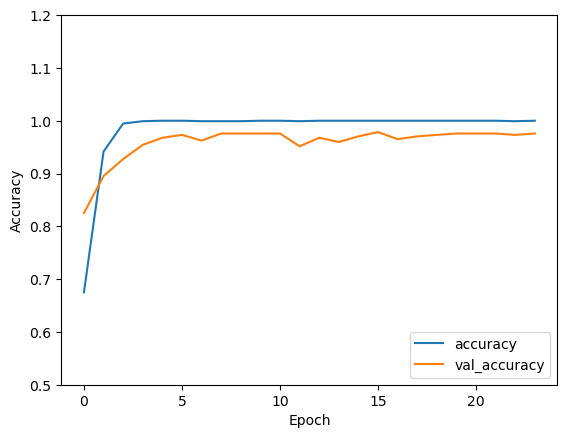

In [21]:
plt.plot(result_D.history['accuracy'], label='accuracy')
plt.plot(result_D.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.2])
plt.legend(loc='lower right')